In [3]:
#|default_exp datasets

import os

os.environ["GEOMSTATS_BACKEND"] = "pytorch"

import geomstats.backend as gs
from fastcore.all import *
from nbdev.showdoc import *
import torch

from autometric.utils import *

%load_ext autoreload
%autoreload 2

INFO: Using pytorch backend
INFO: Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO: NumExpr defaulting to 8 threads.


# Datasets
> What's on the tin! Pytorch utils to load our datasets, to make future use of them exceptionally easy.

**Notebook TODOs**

- [ ] The intrinsic coords are off by some rounding errors from the truth. Fix this. It involves the scaling, possible when ints are involved.

# Geometric Basis

Here we equip our datasets with *metrics*, allowing easy comparison with the ground truth. For consistency, we implement these manifolds as PyTorch immersions, so we can directly apply the goodness in `1 Geometer's Delight`.

In [4]:
#|export
import numpy as np
import scipy.optimize as opt
import sympy as sp
import torch

def manifold_density(f, variables):
    G = sp.Matrix.zeros(len(variables), len(variables))
    for i, x1 in enumerate(variables):
        for j, x2 in enumerate(variables):
            G[i,j] = (sp.diff(f, x1).T  * sp.diff(f, x2))[0]
    return sp.sqrt(G.det(method="lu"))

def max_value(expr, bounds):
    # Convert sympy expression to numpy function
    vars = list(expr.free_symbols)
    expr_neg = -1*expr
    neg_func = sp.lambdify([vars], expr_neg, 'numpy')

    # Minimize negative of function over range [-1, 1]
    bounds = [bounds for _ in vars] # TODO: fails when there are no vars
    res = opt.minimize(neg_func, np.zeros(len(vars)), bounds=bounds)
    
    # Return maximum value
    return -res.fun
def rejection_sample_from_surface(
        F, # a sympy matrix of size $N \times 1$ representing a surface
        n_points, # number of points to sample
        bounds=[-1,1], # bounds for each variable
        batch_size=1024, # number of points to test sampling at a time
        verbose=False,
        return_latent_vars=False,
):
    if verbose: print("Hey, just woke up")
    vars = sorted(F.free_symbols, key=lambda s: s.name)
    f = manifold_density(F, vars)
    g = 1/((bounds[1]-bounds[0])**len(vars)) # uniform density on [-1, 1] for each variable
    M = max_value(f/g, bounds=bounds) # M >= f/g for all x
    if verbose: print("Computed f, M, g")
    bouncer = (f / (M * g)) #.simplify()
    # print(bouncer)
    points = []
    latent_vars = []
    # convert f to numpy
    F_np = sp.lambdify([vars], F, 'numpy')
    bouncer_np = sp.lambdify([vars], bouncer, 'numpy')
    # add the origin as first point

    if verbose: print("Computed bouncer np")
    while len(points) < n_points:
        euc_coords = np.random.uniform(bounds[0], bounds[1], (batch_size,len(vars)))
        x = np.array(list(map(F_np,euc_coords)))
        if verbose: print("computed sample candidates")
        u = np.random.uniform(0, 1, batch_size)
        # print(u)
        # compute mask of points that pass the bouncer
        bouncer_results = np.array(list(map(bouncer_np,euc_coords)))
        if verbose: print("computed bouncer results")
        mask = u < bouncer_results
        points.extend(x[mask])
        latent_vars.extend(euc_coords[mask])
        if verbose:
            print(f"Points added {np.sum(mask)} for a total of {len(points)}")
        # if u < bouncer_np(euc_coords):
        #     points.extend(x)
    if len(points) > n_points:
        points = points[:n_points]
        latent_vars = latent_vars[:n_points]
    if return_latent_vars: 
        return np.squeeze(np.array(points)), np.squeeze(np.array(latent_vars))
    else: 
        return np.squeeze(np.array(points))

In [46]:
#|export
import torch
# rotation script by xingzhis
def generate_rotation_matrix(n, seed=1):
    """
    Generates a random n-dimensional rotation matrix.
    
    Parameters:
        n (int): The dimension of the rotation matrix to be generated.
    
    Returns:
        np.ndarray: An n x n orthogonal matrix with determinant 1.
    """
    # Start with an identity matrix
    A = np.eye(n)
    np.random.seed(seed)
    for i in range(n):
        for j in range(i+1, n):
            # Generate a random angle
            theta = np.random.uniform(0, 2*np.pi)
            
            # Create the Givens rotation matrix for this angle
            G = np.eye(n)
            cos_theta, sin_theta = np.cos(theta), np.sin(theta)
            G[i, i] = cos_theta
            G[j, j] = cos_theta
            G[i, j] = -sin_theta
            G[j, i] = sin_theta
            
            # Apply the Givens rotation
            A = np.dot(G, A)
    
    # Ensure the matrix is a rotation matrix (det = 1)
    if np.linalg.det(A) < 0:
        A[:, 0] = -A[:, 0]
    
    return A

def rotate_data_np(data, n=100, seed=1, return_rot_mat=False, rotation_matrix=None):
    if rotation_matrix is None:
        rotation_matrix = generate_rotation_matrix(n, seed)
    rotated_data = np.c_[data, np.zeros((data.shape[0],n - data.shape[1]))] @ rotation_matrix
    if return_rot_mat:
        return rotated_data, rotation_matrix
    return rotated_data


def rotate_data(data, n=100, seed=1, return_rot_mat=False, rotation_matrix=None):
    if rotation_matrix is None:
        rotation_matrix = torch.tensor(generate_rotation_matrix(n, seed), dtype=torch.float64)
    data = torch.tensor(data)
    zeros = torch.zeros((data.shape[0], n - data.shape[1]))
    rotated_data = torch.cat((data, zeros), dim=1) @ rotation_matrix
    if return_rot_mat:
        return rotated_data, rotation_matrix
    return rotated_data

## ToyManifold Class

In [197]:
#|export
from autometric.metrics import PullbackMetric
from autometric.connections import LeviCivitaConnection
from autometric.manifolds import RiemannianManifold
import sympy as sym
import numpy as np
import sympytorch
import warnings
from torch.func import vmap
import torch
from copy import deepcopy

class ToyManifold:
    def __init__(
        self,
        F, # parameterization of manifold, as a sympy matrix of size $N \times 1$
        variable_bounds, 
        num_points = 2000, # num points to sample
        seed = None,
        rotation_dimension:int = None, # if supplied, will randomly rotate the manifold into this dimension
        noise:float = 0, # if supplied, will add gaussian noise to the manifold with this standard deviation
    ):
        if seed is not None:
            np.random.seed(seed)
        self.F = F
        params = sorted(F.free_symbols, key=lambda s: s.name)
        self.param_list = [str(f) for f in params]
        self.intrinsic_dimension = len(self.param_list)
        self.variable_bounds = variable_bounds
        self.rotation_matrix = None
        self.X, self.intrinsic_coords = self.sample(num_points)
        self.X = torch.tensor(self.X, dtype=torch.float64)
        self.intrinsic_coords = torch.tensor(self.intrinsic_coords, dtype=torch.float64)
        # scale intrinsic coords back to 0,1
        self.intrinsic_coords = (self.intrinsic_coords - torch.min(self.intrinsic_coords))/(torch.max(self.intrinsic_coords)-torch.min(self.intrinsic_coords))
        self.X_ground_truth = self.X.clone()
        if rotation_dimension is not None:
            self.X, self.rotation_matrix = rotate_data(self.X, n = rotation_dimension, seed = seed, return_rot_mat = True)
        if noise:
            self.X = self.X + np.random.normal(0, noise, self.X.shape)
    
    def compute_metrics(self, compute_immersion = True):
        # compute metric information
        if compute_immersion:
            self.compute_immersion()
        self.metric = PullbackMetric(self.intrinsic_dimension, self.immersion)
        self.connection = LeviCivitaConnection(self.intrinsic_dimension, self.metric)
        self.manifold = RiemannianManifold(self.intrinsic_dimension, (1,1), metric = self.metric, connection = self.connection)
        # Compute basic manifold quantities
        try:
            self.ks = self.manifold.scalar_curvature(base_point = self.intrinsic_coords)
        except:
            warnings.warn("Something went awry during the scalar curvature computation.")

    def sample(
            self, num_points
    ):
        return rejection_sample_from_surface(
            F = self.F,
            n_points = num_points,
            bounds = self.variable_bounds,
            return_latent_vars=True,
        )
    
    def compute_immersion(self):
        # turns sympy extression into a pytorch function
        list_F = [item for sublist in self.F.tolist() for item in sublist]
        self.pytorch_function = sympytorch.SymPyModule(expressions = list_F)  
        # convert into a generic pytorch function that takes uniform samples in [0,1] and converts them to the right stuff.
        # the jacfwd functions from functorch go nuts with some negative inputs; hence the restriction.
        self.immersion = lambda x : self.pytorch_function(
            **{param: (x[i]*(self.variable_bounds[1] - self.variable_bounds[0]) + self.variable_bounds[0]) for i, param in enumerate(self.param_list)}
            )
    def decode(self, intrinsic_coords:torch.Tensor):
        intrinsic_coords = torch.tensor(intrinsic_coords)
        if len(intrinsic_coords.size()) == 1:
            intrinsic_coords = intrinsic_coords[None,:]
        return vmap(self.immersion)(intrinsic_coords)
    
    def encode(self, X:torch.Tensor):
        if len(X.size()) == 1:
            X = X[None,:]
        # Converts X to the intrinsic coords. Assumes that X is generated from self.sample
        return self.intrinsic_coords[torch.argmin(torch.cdist(self.X_ground_truth, X), axis=0)]
        
    def plot(self, labels = None, title=""):
        if labels is None: labels = self.ks
        plot_3d(
            self.X.detach().numpy(),
            self.ks.detach().numpy(),
            title = title
        )
        
    def geodesics(self, start_points, end_points, ts):
        """
        Takes start, endpoint pairs in ambient space, and list of times. Returns geodesics and lengths.
        """
        # test if start and end points are tensors
        if isinstance(start_points, np.ndarray):
            start_points = torch.tensor(start_points)
        if isinstance(end_points, np.ndarray):
            end_points = torch.tensor(end_points)
        if isinstance(ts, np.ndarray):
            ts = torch.tensor(ts)
        
        # test if start and end points are among the previously sampled points
        # for each point, find the closest point in the sampled points. If it exceeds a threshold of 1e-3, then raise an error.
        distances_to_sampled_points = torch.cdist(torch.cat([start_points, end_points], dim=0), self.X)
        corresponding_idxs = torch.argmin(distances_to_sampled_points, dim=1)
        
        for i in range(len(start_points)):
            # closest_idx = torch.argmin(distances_to_sampled_points[i], dim=0)
            closest_value = distances_to_sampled_points[i][corresponding_idxs[i]]
            if closest_value > 1e-3:
                raise ValueError(f"Start and end points must be among the previously sampled points. Min dist to manifold is {closest_value}")
            
        # convert the start and end points to the corresponding points in the ground truth data
        start_points = self.X_ground_truth[corresponding_idxs[:len(start_points)]]
        end_points = self.X_ground_truth[corresponding_idxs[len(start_points):]]
            
        gs = []
        lengths = []
        for i in range(len(start_points)):
            g, l = self.pairwise_geodesic(start_points[i], end_points[i], ts)
            # convert g to double
            g = g.double()
            if self.rotation_matrix is not None:
                g = rotate_data(g, n = self.rotation_matrix.shape[0],  return_rot_mat = False, rotation_matrix = self.rotation_matrix)
            gs.append(g)
            lengths.append(l)
            
        # make conversion safe
        lengths = torch.tensor(lengths)
        gs = [g.cpu().detach() for g in gs]
        lengths = lengths.cpu().detach()
        return gs, lengths

## Torus

In [198]:
#|export
class Torus(ToyManifold):
    def __init__(self,num_points = 2000, R=2.0, r=1.0, rotation_dimension:int = None, noise:float = 0, seed = None):
        self.R, self.r = (R,r)
        theta = sym.Symbol('theta')
        phi = sym.Symbol('phi')
        F = sym.Matrix([(R + r*sym.cos(theta))*sym.cos(phi), (R + r*sym.cos(theta))*sym.sin(phi), r*sym.sin(theta)])
        super().__init__(F = F, variable_bounds = [0.0, 2*np.pi], num_points=num_points, rotation_dimension=rotation_dimension, noise=noise, seed = seed)
        self.compute_metrics()
    def scalar_curvature(self, X):
        theta = np.arcsin(X[:,2] / self.r)
        return 1/2*8*np.cos(theta)/(5 + np.cos(theta))

In [199]:
T = Torus()
x = torch.tensor([0.0,0.0])#torch.rand(2)
T.metric.metric_matrix(base_point = x)

tensor([[355.3058,   0.0000],
        [  0.0000,  39.4784]], dtype=torch.float64, grad_fn=<MmBackward0>)

In [200]:
# test that the scalar curvature computed with the metric matches the real scalar curvature
assert np.allclose(T.manifold.scalar_curvature(base_point = x).detach().numpy(),T.scalar_curvature(T.immersion(x).detach().numpy()[None,:])[0])

In [201]:
assert torch.allclose(
    vmap(T.immersion)(T.intrinsic_coords),
    T.X,
    atol = 1e-2
)

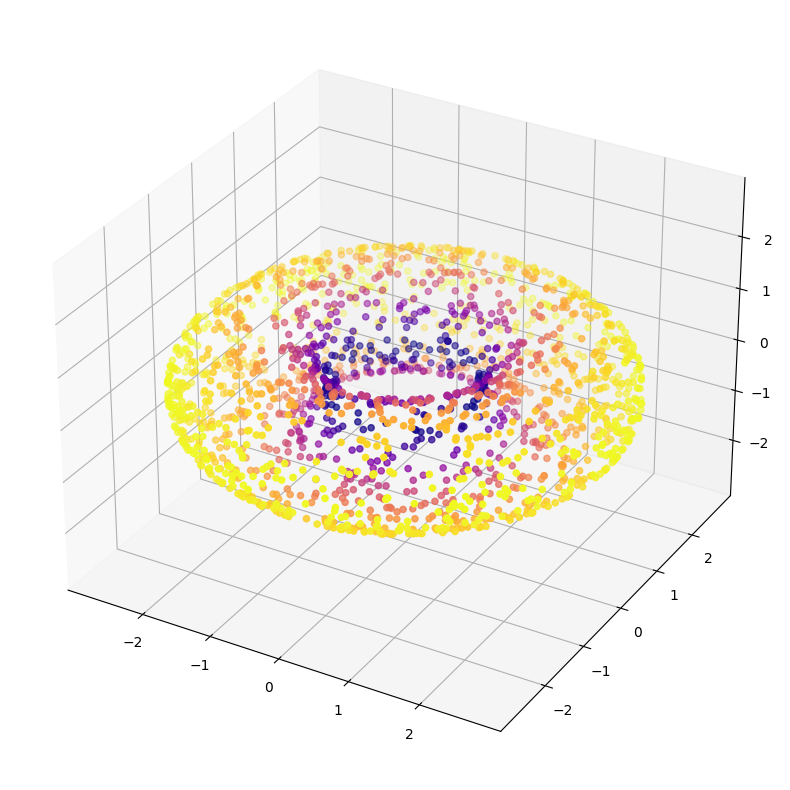

In [202]:
T.plot()

## Saddle

The library I'm using to convert SymPy expressions to PyTorch modules has some problems with squares, quite possibly among other things. Which is why, for this class, I'm overriding the immersion with a PyTorch version.

In [203]:
#|export
class Saddle(ToyManifold):
    def __init__(self, num_points = 2000, a=1, b = 1, rotation_dimension:int = None, noise:float = 0, seed = None):
        # d = intrinsic_dim
        self.a, self.b = (a,b)
        x = sym.Symbol("x")
        y = sym.Symbol("y")
        F = sym.Matrix(
            [x,y,self.a*x**2 - self.b*y**2]
        )
        # vars = sp.symbols('x0:%d' % d)
        # F = sp.Matrix([*vars])
        # for i in range(d,d+1):
        #     F = F.row_insert(i, sp.Matrix([intensity*sum([(1)**j * vars[j]**2 for j in range(d)])]))
        #     print(F)
        super().__init__(F, variable_bounds = [-1, 1], num_points = num_points, rotation_dimension=rotation_dimension, noise=noise, seed = seed)
        self.compute_metrics(compute_immersion=False)
    def immersion(self, tensor_input):
        def pointwise_immersion(tensor_input):
            # scale input with bounds
            tensor_input = tensor_input*(self.variable_bounds[1] - self.variable_bounds[0]) + self.variable_bounds[0]
            x = tensor_input[0]
            y = tensor_input[1]
            return torch.vstack(
                [x, y, self.a*torch.square(x) - self.b*torch.square(y)]
            )
        if len(tensor_input.size()) == 1:
            return torch.squeeze(pointwise_immersion(tensor_input))
        else:
            return torch.squeeze(vmap(pointwise_immersion)(tensor_input))
    

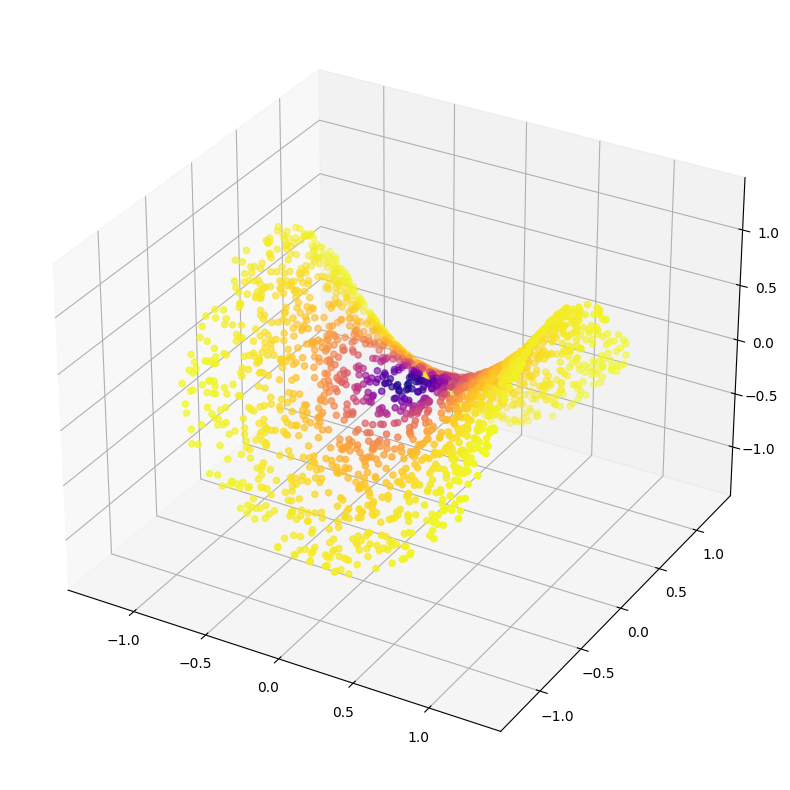

In [204]:
saddle_test = Saddle()
plot_3d(saddle_test.X, saddle_test.ks)

In [205]:
torch.allclose(
    vmap(saddle_test.immersion)(saddle_test.intrinsic_coords),
    saddle_test.X,
    atol = 1e-2
)

True

In [206]:
saddle_test.metric.metric_matrix(saddle_test.intrinsic_coords)

tensor([[[13.9529,  8.6680],
         [ 8.6680, 11.5490]],

        [[ 4.6429,  0.0455],
         [ 0.0455,  4.0032]],

        [[14.1190,  2.3930],
         [ 2.3930,  4.5659]],

        ...,

        [[ 4.3394,  1.5541],
         [ 1.5541, 11.1159]],

        [[ 4.4925,  2.0800],
         [ 2.0800, 12.7840]],

        [[11.0411, -4.2525],
         [-4.2525,  6.5683]]], dtype=torch.float64)

## Ellipsoid

In [207]:
#|export
class Ellipsoid(ToyManifold):
    def __init__(self, num_points = 2000, a=3, b=2, c=1, rotation_dimension:int = None, noise:float = 0, seed = None):
        theta = sym.Symbol("theta")
        phi = sym.Symbol("phi")
        F = sym.Matrix(
            [a*sym.cos(theta)*sym.sin(phi),b*sym.sin(theta)*sym.sin(phi),c*sym.cos(phi)]
        )
        super().__init__(F, [0.0,2*np.pi], num_points = num_points, rotation_dimension = rotation_dimension, noise = noise, seed = seed)
        self.compute_metrics()

In [208]:
elliptest = Ellipsoid()

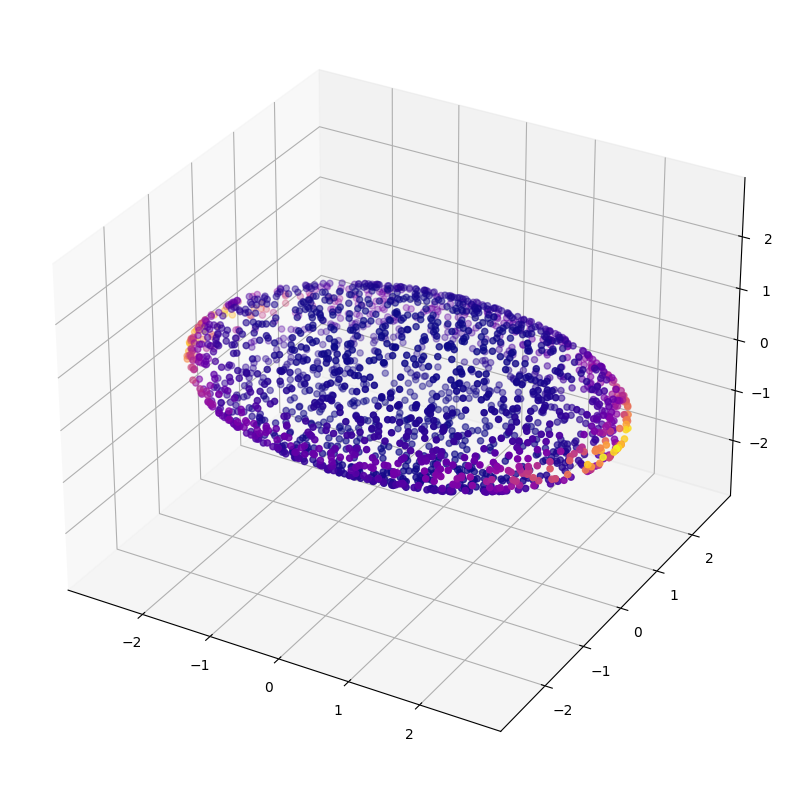

In [209]:
plot_3d(elliptest.X,elliptest.ks)

In [210]:
elliptest.intrinsic_coords[0]

tensor([0.3288, 0.6248], dtype=torch.float64)

In [211]:
elliptest.manifold.ricci_tensor(elliptest.intrinsic_coords)

tensor([[[ -41.2444,    8.5775],
         [   8.5775,  -18.4089]],

        [[  -2.7037,   -0.9822],
         [  -0.9822,  -13.2213]],

        [[-148.6485,   11.0117],
         [  11.0117,  -53.0914]],

        ...,

        [[  -0.8481,   -0.5154],
         [  -0.5154,  -10.9776]],

        [[  -2.0571,   -1.6193],
         [  -1.6193,   -9.5704]],

        [[-224.9220,    5.6042],
         [   5.6042,  -38.0351]]])

## Sphere

In [212]:
#|export
class Sphere(ToyManifold):
    def __init__(self, num_points = 2000, r = 1, rotation_dimension:int = None, noise:float = 0, seed = None):
        self.r = r
        theta = sym.Symbol("theta")
        phi = sym.Symbol("phi")
        F = sym.Matrix(
            [r*sym.cos(theta)*sym.sin(phi),r*sym.sin(theta)*sym.sin(phi),r*sym.cos(phi)]
        )
        super().__init__(F, [0.0,2*np.pi], num_points = num_points, rotation_dimension = rotation_dimension, noise = noise, seed = seed)
        self.compute_metrics()
    def pairwise_geodesic(self, 
                 a, # Coordinates in ambient space
                 b, 
                 ts = None, # length of this is the number of times to sample along the geodesic
                 tolerance = 0.02
                 ):
        """
        Returns geodesic in ambient space between points a and b.
        """
        # if a and b are 2d, convert to 1d
        a = torch.squeeze(a)
        b = torch.squeeze(b)
        # get a linspace line between the two points
        if ts is None:
            ts = torch.linspace(0,1,20)
        g = torch.zeros(len(ts), 3)
        g[:,0] = torch.linspace(a[0], b[0], len(ts))
        g[:,1] = torch.linspace(a[1], b[1], len(ts))
        g[:,2] = torch.linspace(a[2], b[2], len(ts))
        # normalize each row in g to have unit length
        g = g / torch.linalg.norm(g, dim=1, keepdim=True)
        
        # compute length of geodesic
        angle = torch.linalg.norm(torch.cross(a, b, dim=-1))/self.r**2
        length = self.r * angle
        
        # cross = torch.cross(a, b, dim=-1)
        # agreement_with_cross = torch.func.vmap(lambda x: torch.dot(cross, x))(self.X)
        # great_circle_points = self.X[torch.abs(agreement_with_cross) < tolerance]
        # # restrict to points on the right side
        # agreement_with_sign = torch.func.vmap(lambda x: torch.dot(a + b, x))(great_circle_points)
        # great_circle_points = great_circle_points[agreement_with_sign > 0]
        return g, length
    def latent_geodesic(self,
                        a, b, 
                        ts = None, # Ignored. For compatibility with other geodesic functions. 
                        tolerance = 0.02):
        # if a and b are 1d, convert to 2d
        a = self.decode(a)
        b = self.decode(b)
        return self.encode(self.geodesic(a, b, tolerance = tolerance)[1])

In [213]:
S = Sphere()
points, length = S.pairwise_geodesic(S.X[0], S.X[1], ts = np.linspace(0,1,1000),tolerance=0.02)

In [214]:
gs, ls = S.geodesics(S.X[:10], S.X[10:20], ts= np.linspace(0,1,100))

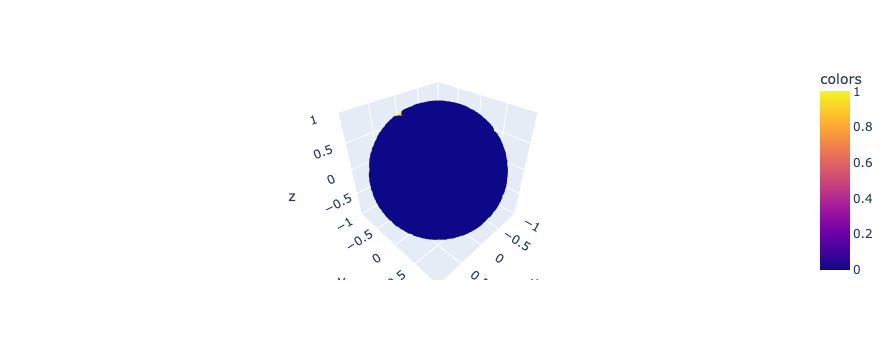

In [215]:
plot_3d_with_geodesics(S.X, gs)

## Hemisphere

In [216]:
#|export
class Hemisphere(Sphere):
    def __init__(self, num_points = 2000, r = 1, threshold=0, rotation_dimension:int = None, noise:float = 0, seed = None):
        super().__init__(num_points, r, rotation_dimension=rotation_dimension, noise=noise, seed = seed)
        hemisphere_mask = self.X[:,2] > threshold
        self.X = self.X[hemisphere_mask]
        self.X_ground_truth = self.X_ground_truth[hemisphere_mask]

In [217]:
S = Hemisphere()
gs, ls = S.geodesics(S.X[70:90], S.X[470:490], np.linspace(0,1,100))

In [218]:
plot_3d_with_geodesics(S.X, gs)

## Swiss Roll

In [219]:
#|export
class SwissRoll(ToyManifold):
    def __init__(self, num_points = 2000, r = 1, height = 21, delay = 1, num_spirals = 1.5, rotation_dimension:int = None, noise:float = 0, seed = None):
        self.r = r
        height = height 
        theta = sym.Symbol("theta")
        phi = sym.Symbol("phi")
        t = num_spirals * sp.pi * (delay + 2*theta) # Sklearn's parameterization of the swiss roll
        F = sym.Matrix(
            [r*sym.cos(t)*t,height*(phi), r*sym.sin(t)*t]
        )
        super().__init__(F, [0.0,1.0], num_points = num_points, rotation_dimension = rotation_dimension, noise = noise, seed = seed)
        self.compute_metrics()
    def pairwise_geodesic(self, 
                 a, # Coordinates in ambient space
                 b, 
                 ts,
                 tolerance = 0.02
                 ):
        """
        Returns geodesic in ambient space between points a and b.
        """
        # if a and b are 2d, convert to 1d
        a = torch.squeeze(a)
        b = torch.squeeze(b)
        # send to latent space
        a = self.encode(a)
        b = self.encode(b)
        # compute pairwise geodesics
        g, length = self.pairwise_latent_geodesic(a, b, ts = ts, tolerance = tolerance)
        return self.decode(g), length
        
    def pairwise_latent_geodesic(self,
                        a, b, # coordinates in latent space
                        ts, 
                        tolerance = 0.02):
        # geodesics on the swiss roll are just straight lines
        a = torch.squeeze(a)
        b = torch.squeeze(b)
        g = torch.zeros(len(ts), 2)
        g[:,0] = torch.linspace(a[0], b[0], len(ts))
        g[:,1] = torch.linspace(a[1], b[1], len(ts))
        length = torch.linalg.norm(a - b)
        return g, length

In [220]:
swissroll = SwissRoll(num_points = 2000, seed = 42, rotation_dimension=3)

/tmp/ipykernel_3310197/2137540610.py:51: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



In [221]:
g, l = swissroll.pairwise_geodesic(swissroll.X[1690], swissroll.X[61], torch.arange(1000)) 

/tmp/ipykernel_3310197/2536377915.py:75: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



In [222]:
gs, ls = swissroll.geodesics(swissroll.X[:10], swissroll.X[350:360], ts = np.linspace(0,1,1000))

/tmp/ipykernel_3310197/2536377915.py:75: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipykernel_3310197/2137540610.py:51: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



In [223]:
swissroll.X.dtype

torch.float64

In [224]:
swissroll.rotation_matrix.dtype

torch.float64

In [225]:
plot_3d_with_geodesics(swissroll.X, gs)

In [226]:
help(plot_3d_with_geodesics)

Help on function plot_3d_with_geodesics in module autometric.utils:

plot_3d_with_geodesics(X, geodesics, ground_truth_geodesics=None, s=5, filename=None)
    # %% ../../nbs/library/util.ipynb 6
    # from plotly3d.plot import scatter



In [227]:
ls

tensor([0.2287, 0.7247, 0.4875, 0.2996, 1.2741, 0.5708, 0.7179, 0.3218, 0.4628,
        0.3148], dtype=torch.float64)

# PyTorch Machinery

In [228]:
#|export
import torch

class PointcloudDataset(torch.utils.data.Dataset):
    def __init__(self, pointcloud):
        self.pointcloud = torch.tensor(pointcloud, dtype=torch.float32)
        
    def __len__(self):
        return len(self.pointcloud)
    
    def __getitem__(self, idx):
        return self.pointcloud[idx]

class PointcloudWithDistancesDataset(torch.utils.data.Dataset):
    def __init__(self, pointcloud, distances, batch_size = 64):
        self.pointcloud = torch.tensor(pointcloud, dtype=torch.float32)
        self.distances = torch.tensor(distances, dtype=torch.float32)
        self.batch_size = batch_size

    def __len__(self):
        return len(self.pointcloud)
    
    def __getitem__(self, idx):
        batch_idxs = torch.randperm(len(self.pointcloud))[:self.batch_size]
        batch = {}
        batch['x'] = self.pointcloud[batch_idxs]
        batch['d'] = self.distances[batch_idxs][:,batch_idxs]
        return batch

In [229]:
#|export
def dataloader_from_pointcloud_with_distances(pointcloud, distances, batch_size = 64):
    dataset = PointcloudWithDistancesDataset(pointcloud, distances, batch_size)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=None, shuffle=True)
    return dataloader

In [230]:
#|export
def train_and_testloader_from_pointcloud_with_distances(
    pointcloud, distances, batch_size = 64, train_test_split = 0.8
):
    X = pointcloud
    D = distances
    split_idx = int(len(X)*train_test_split)
    X_train = X[:split_idx]
    X_test = X[split_idx:]
    D_train = D[:split_idx,:split_idx]
    D_test = D[split_idx:,split_idx:]
    trainloader = dataloader_from_pointcloud_with_distances(X_train, D_train, batch_size)
    testloader = dataloader_from_pointcloud_with_distances(X_test, D_test, batch_size)
    return trainloader, testloader

# Compiling the datasets
Though defined in other notebooks, we compile the datasets here for ease of use.

In [231]:
#|export
import numpy as np
import plotly.graph_objects as go
import chart_studio
import chart_studio.plotly as py
import chart_studio.tools as tls

def plot_3d_vector_field(X, *vector_fields, names=None, arrow_length=0.5, upload_to_information_superhighway = False, username = "", api_key = "", filename = ""):
    """
    Create a 3D quiver plot with multiple vector fields.

    Args:
        X (list of tuples or arrays): Collection of points in 3D space.
        *vector_fields: Variable number of vector fields (lists of tuples or arrays).
        arrow_length (float): Scaling factor for arrow lengths.

    Returns:
        None
    """
    if names is None:
        names = [f"Vector Field {i}" for i in range(len(vector_fields))]
    
    fig = go.Figure()

    # Convert to NumPy array for vectorized operations
    X = np.array(X)

    # Generate a list of colors
    colors = ['blue', 'red', 'green', 'orange', 'purple', 'yellow', 'brown', 'pink', 'grey', 'cyan']
    if len(vector_fields) > len(colors):
        # Generate more colors if needed
        additional_colors = np.random.choice(colors, size=(len(vector_fields) - len(colors)))
        colors.extend(additional_colors)

    # Function to add arrows (vectors)
    def add_arrows(X, V, color, name):
        V = np.array(V) * arrow_length
        end_points = X + V
    
        # Arrows (cones)
        fig.add_trace(go.Cone(
            x=end_points[:, 0],
            y=end_points[:, 1],
            z=end_points[:, 2],
            u=V[:, 0],
            v=V[:, 1],
            w=V[:, 2],
            sizemode='absolute',
            sizeref=0.1,
            showscale=False,
            colorscale=[[0, color], [1, color]],
            cmin=0,
            cmax=1,
            name=name,
            legendgroup=name,
            showlegend=True  # Set to True to show in legend
        ))
    
        # Lines (arrow shafts)
        for start, end in zip(X, end_points):
            fig.add_trace(go.Scatter3d(
                x=[start[0], end[0]],
                y=[start[1], end[1]],
                z=[start[2], end[2]],
                mode='lines',
                line=dict(width=3, color=color),
                showlegend=False  # Set to False to avoid duplicate legend entries
            ))


    # Markers for points
    fig.add_trace(go.Scatter3d(
        x=X[:, 0],
        y=X[:, 1],
        z=X[:, 2],
        mode='markers',
        marker=dict(size=5, color='black'),
        name='Points',
        showlegend=False
    ))

    # Add arrows for each vector field
    for i, vector_field in enumerate(vector_fields):
        add_arrows(X, vector_field, colors[i % len(colors)], names[i])

    # Set axis labels
    fig.update_layout(scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'
    ), title=filename)

    # Show the plot
    fig.show()
    if upload_to_information_superhighway:
        url = py.plot(fig, filename = filename, auto_open=False)
        print("Your plot is now live at ",url)


In [232]:
#|export
def sphere_with_normals(
    n_points
):
    X, ks = sphere(n_points)
    N = X
    return X, N

# Exporting Datasets

In [239]:
#|export
import os
from fastcore.script import *
from autometric.branch_datasets import Branch

@call_parse
def export_datasets(
    foldername:str,
    num_geodesics = 20,    
    num_points_per_geodesic = 1000,
    seed = 480851,
):
    """
    Saves all of the datasets above into npz files.
    """
    # check if the folder foldername exists. If not create it.
    if not os.path.exists(foldername):
        os.makedirs(foldername)
        
    np.random.seed(seed)
    dsets = {
        'Nice Hemisphere' : Hemisphere(num_points = 3000, rotation_dimension = None, noise = 0, seed = seed), 
        'Neutral Hemisphere' : Hemisphere(num_points = 3000, rotation_dimension = 5, noise = 0.1, seed = seed), 
        'Evil Hemisphere' : Hemisphere(num_points = 3000, rotation_dimension = 15, noise = 0.3, seed = seed),

        'Nice Swiss Roll' : SwissRoll(num_points = 3000, r = 1, height = 21, delay = 1, num_spirals = 1.5, rotation_dimension=None, noise = 0, seed = seed), # sklearn parameters
        'Neutral Swiss Roll' : SwissRoll(num_points = 3000, r = 1, height = 21, delay = 1, num_spirals = 1.5, rotation_dimension=5, noise = 0.1, seed = seed), # sklearn parameters
        'Evil Swiss Roll' : SwissRoll(num_points = 3000, r = 1, height = 21, delay = 1, num_spirals = 1.5, rotation_dimension=15, noise = 0.3, seed = seed), # sklearn parameters
        
        'Nice Branch' : Branch(dimension = 3, num_samples = 3000, path_length = 3, max_branches = 3, seed = seed),
        'Neutral Branch' : Branch(dimension = 5, num_samples = 3000, path_length = 4, max_branches = 4, seed = seed),
        'Evil Branch' : Branch(dimension = 15, num_samples = 3000, path_length = 5, max_branches = 5, seed = seed),
    }
    for dname, dset in zip(dsets.keys(), dsets.values()):
        print(f"Creating {dname}")
        # make dname filename safe
        dname = dname.replace(" ", "_")
        dname = dname.lower()
        # get geodesics
        # first sample points from dset.X
        X = dset.X
        X_ground_truth = dset.X_ground_truth
        
        # if these are torch tensors, convert to numpy
        if isinstance(X, torch.Tensor):
            X = X.detach().numpy()
            X_ground_truth = X_ground_truth.detach().numpy()
            
        endpoint_idxs = np.random.randint(0, dset.X.shape[0], size = num_geodesics*2)
        start_points = X[endpoint_idxs[:num_geodesics]]
        end_points = X[endpoint_idxs[num_geodesics:]]
        ts = np.linspace(0, 1, num_points_per_geodesic)
        
        gs, ls = dset.geodesics(start_points, end_points, ts)
        
        # convert to numpy arrays
        if isinstance(gs[0], torch.Tensor):
            gs = [g.detach().numpy() for g in gs]
            ls = ls.numpy()

        np.savez(
            os.path.join(foldername, f'{dname}.npz'), 
            X = X, 
            X_ground_truth = X_ground_truth,
            start_points = start_points, 
            end_points = end_points,
            geodesics = gs,
            geodesic_lengths = ls,
            
        )

In [240]:
export_datasets("../../data/manifold_test/", seed = 12490132)

/tmp/ipykernel_3310197/2137540610.py:51: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Creating Nice Hemisphere
Creating Neutral Hemisphere
Creating Evil Hemisphere
Creating Nice Swiss Roll
Creating Neutral Swiss Roll
Creating Evil Swiss Roll
Creating Nice Branch
Creating Neutral Branch


/tmp/ipykernel_3310197/2536377915.py:75: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Creating Evil Branch


In [235]:
!nbdev_export

In [236]:
H = Hemisphere(num_points = 3000, rotation_dimension = None, noise = 0, seed = 135135)

In [237]:
H.X

tensor([[ 0.1325,  0.8222,  0.5536],
        [-0.9872,  0.0937,  0.1293],
        [-0.6291,  0.7760,  0.0451],
        ...,
        [ 0.6824, -0.3523,  0.6405],
        [ 0.8561, -0.1050,  0.5060],
        [ 0.6907, -0.6165,  0.3780]], dtype=torch.float64)

In [238]:
H.X_ground_truth

tensor([[ 0.1325,  0.8222,  0.5536],
        [-0.9872,  0.0937,  0.1293],
        [-0.6291,  0.7760,  0.0451],
        ...,
        [ 0.6824, -0.3523,  0.6405],
        [ 0.8561, -0.1050,  0.5060],
        [ 0.6907, -0.6165,  0.3780]], dtype=torch.float64)